In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from rl.agent import *
from rl.utils import *
import gym
from gym import wrappers
import math

GAMMA = 0.95

In [2]:
def build_model(state_size):
    model = Sequential()

    model.add(Linear(state_size, 10))
    model.add(Tanh())

    model.add(Linear(10, 2))
    model.add(SoftMax())
    return model


def create_agent(x):
    env = gym.make('CartPole-v1')
    return REINFORCEAgent(env, 498)


def calc_baseline(r_rewards):
    max_steps = r_rewards.map(lambda x: x.shape[0]).max()
    pad = r_rewards.map(lambda x: np.pad(x, (0, max_steps-x.shape[0]), 'constant'))
    sum, count = pad.map(lambda x: (x, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    mean = sum / count
    return mean


def normalize(records, eps=1e-8):
    stats = records.map(lambda x: x[2]).stats()

    mean = stats.mean()
    std = stats.sampleStdev()

    return records.map(lambda x: (x[0], x[1], (x[2] - mean) / (std + eps)))

In [3]:
init_engine()
init_executor_gateway(sc)
redire_spark_logs()

In [4]:
node_num, core_num = get_node_and_core_number()
parallelism = node_num * core_num

In [5]:
# test environment on driver
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "/tmp/cartpole-experiment", video_callable=lambda x: True, force=True)
test_agent = REINFORCEAgent(env, 1000)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = build_model(state_size)
criterion = PGCriterion()

# create and cache several agents on each partition as specified by parallelism
# and cache it
with DistributedAgents(sc, create_agent=create_agent, parallelism=parallelism) as a:
    # a.agents is a RDD[Agent]
    agents = a.agents
    optimizer = None
    num_trajs_per_part = int(math.ceil(15.0 / parallelism))
    mean_std = []

    for i in range(60):
        with SampledTrajs(sc, agents, model, num_trajs_per_part=num_trajs_per_part) as trajs:
            # samples is a RDD[Trajectory]
            trajs = trajs.samples \
                .map(lambda traj: (traj.data["observations"],
                                   traj.data["actions"],
                                   traj.data["rewards"]))

            rewards_stat = trajs.map(lambda traj: traj[2].sum()).stats()
            
            reward_mean = rewards_stat.mean()
            reward_std = rewards_stat.sampleStdev()
            reward_max = rewards_stat.max()
            mean_std.append([reward_mean, reward_std])

            print "*********** steps %s **************" % i
            print "reward mean:", reward_mean
            print "reward std:", reward_std
            print "reward max:", reward_max

            # calculate the discounted sum of future rewards
            trajs = trajs.map(lambda x: (x[0], x[1], discounted_sum_of_future_rewards(x[2], GAMMA)))

            # calculate advantages
            baseline = calc_baseline(trajs.map(lambda x: x[2]))
            trajs = trajs.map(lambda x: (x[0], x[1], x[2] - baseline[:len(x[2])]))

            # trajectories to records
            records = trajs.flatMap(lambda x: [(x[0][i], x[1][i], x[2][i]) for i in range(len(x[0]))])

            num_records = records.count()
            batch_size = num_records - num_records % parallelism

            print "total %s num_records" % num_records
            print "using %s batch_size" % batch_size

            # normalize advantages
            normalized = normalize(records)

            # to bigdl sample
            data = normalized.map(obs_act_adv_to_sample)

            # update one step
            if optimizer is None:
                optimizer = Optimizer(model=model,
                                      training_rdd=data,
                                      criterion=criterion,
                                      optim_method=RMSprop(learningrate=0.005),
                                      end_trigger=MaxIteration(1),
                                      batch_size=batch_size)
            else:
                optimizer.set_traindata(data, batch_size)
                optimizer.set_end_when(MaxIteration(i + 1))

            model = optimizer.optimize()

            if (i + 1) % 10 == 0:
                import time

                start = time.time()
                step = test_agent.sample(model, num_trajs=1)[0].data["actions"].shape[0]
                end = time.time()
                print "************************************************************************"
                print "*****************sample video generated, %s steps**********************" % step
                print "************************************************************************"

env.close()

INFO:gym.envs.registration:Making new env: CartPole-v1
[2018-02-28 11:26:00,542] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 19 monitor files from previous run (because force=True was provided)
[2018-02-28 11:26:00,544] Clearing 19 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000000.mp4
[2018-02-28 11:26:00,546] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000000.mp4


creating: createSequential
creating: createLinear
creating: createTanh
creating: createLinear
creating: createSoftMax
creating: createPGCriterion
*********** steps 0 **************
reward mean: 24.3125
reward std: 15.0895935443
reward max: 72.0
total 389 num_records
using 388 batch_size
creating: createRMSprop
creating: createMaxIteration
creating: createDistriOptimizer
*********** steps 1 **************
reward mean: 27.1875
reward std: 16.7300876666
reward max: 67.0
total 435 num_records
using 432 batch_size
creating: createMaxIteration
*********** steps 2 **************
reward mean: 39.1875
reward std: 19.3708328852
reward max: 89.0
total 627 num_records
using 624 batch_size
creating: createMaxIteration
*********** steps 3 **************
reward mean: 36.0
reward std: 18.5256578831
reward max: 84.0
total 576 num_records
using 576 batch_size
creating: createMaxIteration
*********** steps 4 **************
reward mean: 38.75
reward std: 27.2066168422
reward max: 114.0
total 620 num_recor

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000001.mp4
[2018-02-28 11:26:37,838] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000001.mp4



************************************************************************
*****************sample video generated, 145 steps**********************
************************************************************************
*********** steps 10 **************
reward mean: 176.5
reward std: 130.905054652
reward max: 498.0
total 2824 num_records
using 2824 batch_size
creating: createMaxIteration
*********** steps 11 **************
reward mean: 176.1875
reward std: 69.4158663419
reward max: 324.0
total 2819 num_records
using 2816 batch_size
creating: createMaxIteration
*********** steps 12 **************
reward mean: 258.9375
reward std: 97.1112549262
reward max: 498.0
total 4143 num_records
using 4140 batch_size
creating: createMaxIteration
*********** steps 13 **************
reward mean: 225.1875
reward std: 119.773240612
reward max: 485.0
total 3603 num_records
using 3600 batch_size
creating: createMaxIteration
*********** steps 14 **************
reward mean: 321.4375
reward std: 129.52990

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000002.mp4
[2018-02-28 11:28:47,295] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000002.mp4



************************************************************************
*****************sample video generated, 160 steps**********************
************************************************************************
*********** steps 20 **************
reward mean: 198.9375
reward std: 35.7649153035
reward max: 268.0
total 3183 num_records
using 3180 batch_size
creating: createMaxIteration
*********** steps 21 **************
reward mean: 464.0
reward std: 52.0679043814
reward max: 498.0
total 7424 num_records
using 7424 batch_size
creating: createMaxIteration
*********** steps 22 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 23 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 24 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_r

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000003.mp4
[2018-02-28 11:32:05,380] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000003.mp4



************************************************************************
*****************sample video generated, 344 steps**********************
************************************************************************
*********** steps 30 **************
reward mean: 324.6875
reward std: 55.8948044693
reward max: 420.0
total 5195 num_records
using 5192 batch_size
creating: createMaxIteration
*********** steps 31 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 32 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 33 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 34 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
usi

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000004.mp4
[2018-02-28 11:35:39,162] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000004.mp4



************************************************************************
*****************sample video generated, 500 steps**********************
************************************************************************
*********** steps 40 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 41 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 42 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 43 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 44 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000005.mp4
[2018-02-28 11:39:18,602] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000005.mp4



************************************************************************
*****************sample video generated, 500 steps**********************
************************************************************************
*********** steps 50 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 51 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 52 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 53 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 54 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000006.mp4
[2018-02-28 11:42:59,594] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.0.27703.video000006.mp4



************************************************************************

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')
[2018-02-28 11:42:59,654] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')



*****************sample video generated, 500 steps**********************
************************************************************************


(60, 2)


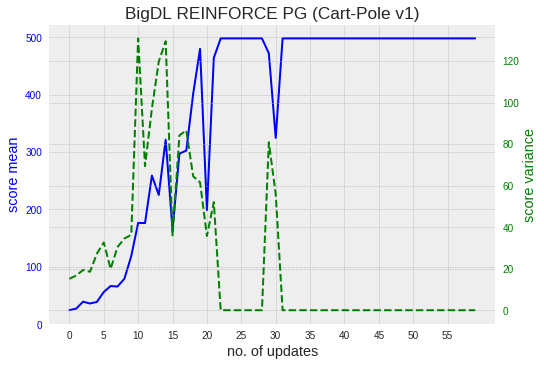

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('bmh')
arr = np.asarray(mean_std)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('no. of updates')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL REINFORCE PG (Cart-Pole v1)');